In [1]:
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt

2025-05-07 23:14:27.779257: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-07 23:14:28.026072: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746639868.126897      79 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746639868.150342      79 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-07 23:14:28.373020: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [ ]:
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

In [2]:
image_size = (180, 180)
batch_size = 64

train_ds, val_ds = keras.utils.image_dataset_from_directory(
                                                                "PetImages",
                                                                validation_split=0.2,
                                                                subset="both",
                                                                seed=1337,
                                                                image_size=image_size,
                                                                batch_size=batch_size)

Found 4000 files belonging to 2 classes.
Using 3200 files for training.
Using 800 files for validation.


I0000 00:00:1746639878.431851      79 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5564 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [3]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

2025-05-07 23:14:49.850818: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


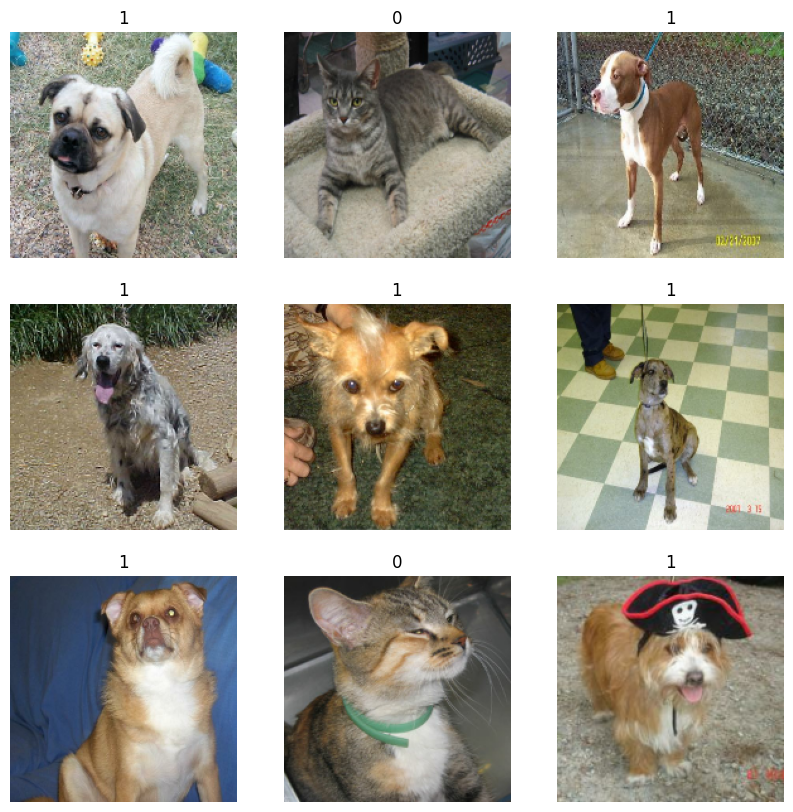

In [4]:
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [5]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]

def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

2025-05-07 23:15:01.686394: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


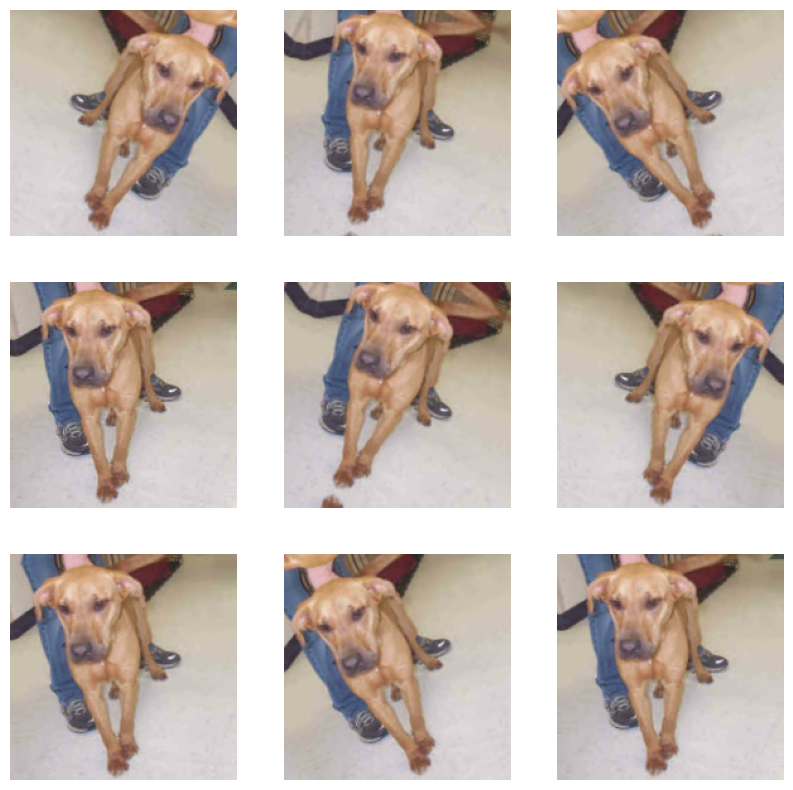

In [6]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

In [7]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(lambda img, label: (data_augmentation(img), label),
                        num_parallel_calls=tf_data.AUTOTUNE)

# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

In [8]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)

In [9]:
model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [10]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 180, 180,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 180, 180,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 90, 90,    │      3,584 │ rescaling[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 90, 90,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 90, 90,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 90, 90,    │          0 │ activation[0][0]  │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d    │ (None, 90, 90,    │     34,176 │ activation_1[0][… │
│ (SeparableConv2D)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 90, 90,    │      1,024 │ separable_conv2d… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 90, 90,    │          0 │ batch_normalizat… │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1  │ (None, 90, 90,    │     68,096 │ activation_2[0][… │
│ (SeparableConv2D)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 90, 90,    │      1,024 │ separable_conv2d… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 45, 45,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 45, 45,    │     33,024 │ activation[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 45, 45,    │          0 │ max_pooling2d[0]… │
│                     │ 256)              │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 45, 45,    │          0 │ add[0][0]         │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_2  │ (None, 45, 45,    │    133,888 │ activation_3[0][… │
│ (SeparableConv2D)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 45, 45,    │      2,048 │ separable_conv2d

 Total params: 2,731,065 (10.42 MB)

 Trainable params: 2,722,777 (10.39 MB)

 Non-trainable params: 8,288 (32.38 KB)

In [11]:
epochs = 5

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]

model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)


In [12]:
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/5


I0000 00:00:1746639946.386654     208 service.cc:148] XLA service 0x87da5f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746639946.387205     208 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti Laptop GPU, Compute Capability 8.6
2025-05-07 23:15:46.562327: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746639947.504669     208 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1746639970.684410     208 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


25/50 ━━━━━━━━━━━━━━━━━━━━ 5s 225ms/step - acc: 0.5693 - loss: 0.6997

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - acc: 0.5810 - loss: 0.6848

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


50/50 ━━━━━━━━━━━━━━━━━━━━ 43s 308ms/step - acc: 0.5814 - loss: 0.6843 - val_acc: 0.5025 - val_loss: 0.6945
Epoch 2/5
17/50 ━━━━━━━━━━━━━━━━━━━━ 7s 242ms/step - acc: 0.6557 - loss: 0.6097

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - acc: 0.6650 - loss: 0.6050

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 248ms/step - acc: 0.6653 - loss: 0.6047 - val_acc: 0.5025 - val_loss: 0.6975
Epoch 3/5
23/50 ━━━━━━━━━━━━━━━━━━━━ 6s 233ms/step - acc: 0.6811 - loss: 0.5694

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - acc: 0.6873 - loss: 0.5663

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 253ms/step - acc: 0.6876 - loss: 0.5660 - val_acc: 0.5025 - val_loss: 0.6983
Epoch 4/5
23/50 ━━━━━━━━━━━━━━━━━━━━ 6s 241ms/step - acc: 0.7041 - loss: 0.5466

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - acc: 0.7180 - loss: 0.5296

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 264ms/step - acc: 0.7182 - loss: 0.5293 - val_acc: 0.5025 - val_loss: 0.6960
Epoch 5/5
21/50 ━━━━━━━━━━━━━━━━━━━━ 7s 245ms/step - acc: 0.7471 - loss: 0.5025

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - acc: 0.7508 - loss: 0.4955

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 269ms/step - acc: 0.7509 - loss: 0.4953 - val_acc: 0.5025 - val_loss: 0.6951


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
This image is 54.31% cat and 45.69% dog.


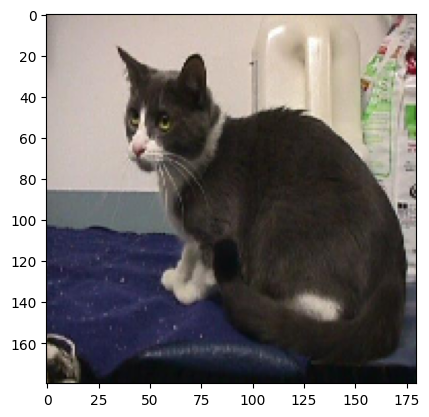

In [14]:
img = keras.utils.load_img("PetImages/Cat/4.jpg", target_size=image_size)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(keras.ops.sigmoid(predictions[0][0]))
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")